In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

%matplotlib inline
%config IPCompleter.greedy=True

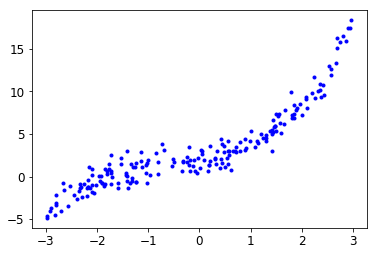

In [16]:
#Create some data. Creating a 3rd degree function

m = 200
X = 6 * np.random.rand(m, 1) - 3
y = 0.3 * X**3 + 0.5 * X**2 + X + 2 + np.random.randn(m,1)

plt.plot(X, y, 'b.')

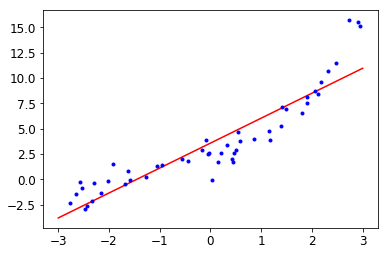

In [13]:
from sklearn.linear_model import LinearRegression

lin_reg_lin = LinearRegression()
lin_reg_lin.fit(X, y.ravel())

x_new = np.linspace(-3, 3, 100).reshape(100, 1)
y_new = lin_reg_lin.predict(x_new)

plt.plot(x_new, y_new, 'r-')
plt.plot(X, y, 'b.')

In [6]:
#adding polynomial features manually

def poly_features(X, degree=2):
    
    x_poly = []

    for row in X[:]:
        row_poly = row.tolist()
        for n in row[:]:
            for d in range(2, degree + 1):
                row_poly.append(n**d)
        x_poly.append(row_poly)
    return x_poly
    
x_poly = poly_features(X, 2)
    
print (X[1:3])
print (x_poly[1:3])


[[ 1.30030718]
 [-1.6732674 ]]
[[1.300307176536677, 1.6907987533527846], [-1.6732673979127437, 2.7998237849176841]]


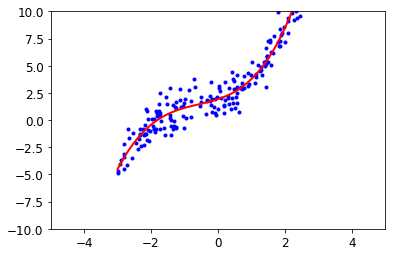

In [32]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly_features.fit_transform(X)

lin_reg_poly = LinearRegression()
lin_reg_poly.fit(X_poly, y)

X_new = np.linspace(-3, 3, 50).reshape(50, 1)
X_new_poly = poly_features.transform(X_new)

y_new_poly = lin_reg_poly.predict(X_new_poly)

plt.axis([-5, 5, -10, 10])
plt.plot(X, y, 'b.')
plt.plot(X_new, y_new_poly,  'r-', linewidth=2)



In [308]:
#Best theta. original polynomial (b + 0.3*x^3 + 0.5*x^2 + x)

lin_reg_poly.intercept_, lin_reg_poly.coef_

(array([ 2.07154365]), array([[ 1.08235493,  0.48794198,  0.29136355]]))

In [39]:
#Plot learning curve. see the training and validation error as the number 
#of training examples increases. For each batch of increasing training examples,
#fit the model and see train/validation error

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2) 
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train_predict, y_train[:m]))
        val_errors.append(mean_squared_error(y_val_predict, y_val))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.axis([0, 170, 0, 6])

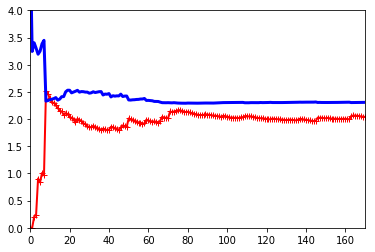

In [289]:
#Underfitting model (degree = 1 features for a 3rd degree polynomial)

lin_reg_test = LinearRegression()
plot_learning_curves(lin_reg_test, X, y)
plt.show()

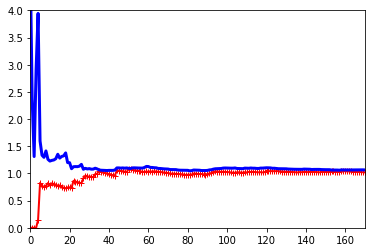

In [290]:
#just right model

lin_reg_test = LinearRegression()
poly_features = PolynomialFeatures(degree=3, include_bias=False)
X_poly_test = poly_features.fit_transform(X)

plot_learning_curves(lin_reg_test, X_poly_test, y)

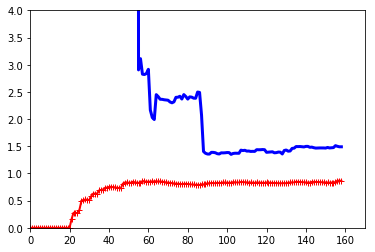

In [318]:
#overfitting model (degree = 20 features for a 3rd degree polynomial)

lin_reg_test = LinearRegression()
poly_features = PolynomialFeatures(degree=20, include_bias=False)
X_poly_test = poly_features.fit_transform(X)

plot_learning_curves(lin_reg_test, X_poly_test, y)

(200, 3)


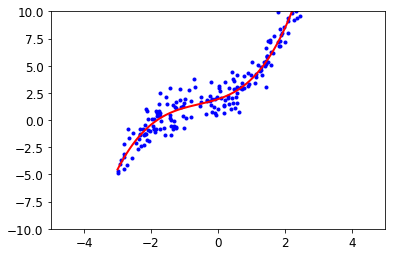

In [33]:
from sklearn.linear_model import Ridge

#Regularized model using Ridge (L2 norm). Can withstand high polynomial degrees without overfitting.
#See also Lasso (L1 norm) regularization. Lasso tends to eliminate the weaker features

poly_features = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly_features.fit_transform(X)

ridge_reg = Ridge(alpha=1, solver="cholesky") 
ridge_reg.fit(X_poly, y)

X_new = np.linspace(-3, 3, 200).reshape(200, 1)
X_new_poly = poly_features.transform(X_new)

print(X_new_poly.shape)

y_new_poly = ridge_reg.predict(X_new_poly)

plt.axis([-5, 5, -10, 10])
plt.plot(X, y, 'b.')
plt.plot(X_new, y_new_poly,  'r-', linewidth=2)




In [55]:
from sklearn.base import clone
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

#Regularization technique - early stopping. Each epoch test validation error. 
#take model with min val error (early stop model)

#warm_start = True. This means that the model will use previous computed coefficients when 
#fit is called. Also, n_iter = 1. We control the iterations manually
sgd_reg = SGDRegressor(n_iter=1, warm_start=True, penalty=None, learning_rate="constant", eta0=0.0005)

minimum_val_error = float("inf") 
best_epoch = None
best_model = None
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

#poly feature and scale
prep_pipeline = Pipeline([
    ('poly_features', PolynomialFeatures(degree=3, include_bias=False)),
    ('std_scaler', StandardScaler()),
])
X_train_poly_scaled = prep_pipeline.fit_transform(X_train)
X_val_poly_scaled = prep_pipeline.fit_transform(X_val)

for epoch in range(1000):
    
    sgd_reg.fit(X_train_poly_scaled, y_train.ravel()) # continues where it left off 
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val_predict, y_val)
    
    #if epoch % 200 == 0: print ('error: ', val_error) 
    if val_error < minimum_val_error:
        #print ('new minimum: ', val_error)
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)

